<a href="https://colab.research.google.com/github/Anspire/Notebooks/blob/master/GAN_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import sys
import numpy as np
from os.path import exists
import matplotlib.pyplot as plt

from keras.datasets import mnist
from keras.optimizers import Adam
from keras.models import load_model
from keras.models import Sequential, Model
from keras.layers import BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Input, Dense, Reshape, Flatten, Dropout

In [0]:
class GAN():
    def __init__(self, img_shape= (28,28,1), latent_dim = 100, loss='binary_crossentropy', optimizer= 'adam', metrics=['accuracy']):
        self.img_shape = img_shape
        self.latent_dim = latent_dim

        ## build generator and named it 'generator'
        self.generator = self.build_generator()
        self.generator.name = 'generator'

        ## build discriminator and set trainable false
        self.discriminator = self.build_discriminator()
        self.discriminator.name = 'discriminator'
        #self.discriminator.trainable = False
        self.discriminator.compile(loss= loss, optimizer=optimizer, metrics= metrics)

        
        ## build combined model
        self.combined = self.build_combine_model()
        self.combined.name = 'combined'
        self.combined.compile(loss= loss, optimizer=optimizer)

    def build_combine_model(self):
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)
        self.discriminator.trainable = False
        validity = self.discriminator(img)
        return Model(z, validity)

    def build_generator(self):
        model = Sequential()
        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):
        model = Sequential()
        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def summary(self):
        self.generator.summary()
        self.discriminator.summary()
        self.combined.summary()

    def save(self, model_path):
        self.generator.save(model_path)

    def save_weights(self, weights_path):
        self.generator.save_weights(weights_path)

    def load_weights(self, weights_path= 'generator_weights.h5'):
        if not exists(weights_path):
            print(weights_path, 'No such file')
            return
        self.generator.load_weights(weights_path)

    def train(self, X_train, epochs, batch_size=128, sample_interval=50):
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            
            gen_imgs = self.generator.predict(noise)

            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            g_loss = self.combined.train_on_batch(noise, valid)
            if epoch % (epochs // 100) == 0:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def predict(self, noise):
        gen_imgs = self.generator.predict(noise)
        gen_imgs = 0.5 * gen_imgs + 0.5
        return gen_imgs

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images%d.png" % epoch)
        plt.show()
        plt.close()

In [11]:
gan = GAN(img_shape= (28,28,1), latent_dim = 100, loss='binary_crossentropy', optimizer= Adam(0.0002, 0.5), metrics=['accuracy'])
gan.load_weights(weights_path= 'generator_weights.h5')
gan.summary()

generator_weights.h5 No such file
Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 100)               0         
_________________________________________________________________
sequential_7 (Sequential)    (None, 28, 28, 1)         1493520   
Total params: 1,493,520
Trainable params: 1,489,936
Non-trainable params: 3,584
_________________________________________________________________
Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
sequential_8 (Sequential)    (None, 1)                 533505    
Total params: 1,067,010
Trainable params: 533,505
Non-trainable params: 533,505
______________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.591536, acc.: 62.50%] [G loss: 0.611771]


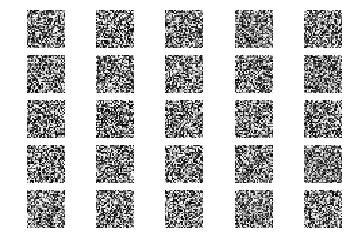

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1000 [D loss: 0.604149, acc.: 69.32%] [G loss: 0.961958]
2000 [D loss: 0.627601, acc.: 64.02%] [G loss: 0.904270]
3000 [D loss: 0.617356, acc.: 65.91%] [G loss: 0.854181]
4000 [D loss: 0.630359, acc.: 68.18%] [G loss: 0.916257]
5000 [D loss: 0.659746, acc.: 63.64%] [G loss: 0.839733]
6000 [D loss: 0.684827, acc.: 48.48%] [G loss: 0.838948]
7000 [D loss: 0.651541, acc.: 60.98%] [G loss: 0.833855]
8000 [D loss: 0.650792, acc.: 64.77%] [G loss: 0.818150]
9000 [D loss: 0.668212, acc.: 61.74%] [G loss: 0.820417]
10000 [D loss: 0.650941, acc.: 60.98%] [G loss: 0.879766]


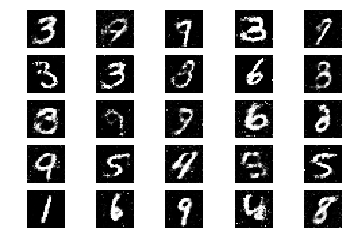

11000 [D loss: 0.693448, acc.: 56.82%] [G loss: 0.839097]
12000 [D loss: 0.667495, acc.: 60.61%] [G loss: 0.841442]
13000 [D loss: 0.687009, acc.: 56.82%] [G loss: 0.834254]
14000 [D loss: 0.655235, acc.: 62.50%] [G loss: 0.850620]
15000 [D loss: 0.662214, acc.: 59.09%] [G loss: 0.808613]
16000 [D loss: 0.694364, acc.: 53.03%] [G loss: 0.856513]
17000 [D loss: 0.675293, acc.: 59.47%] [G loss: 0.867628]
18000 [D loss: 0.670247, acc.: 59.85%] [G loss: 0.814055]
19000 [D loss: 0.670143, acc.: 57.95%] [G loss: 0.918407]
20000 [D loss: 0.654193, acc.: 60.98%] [G loss: 0.859287]


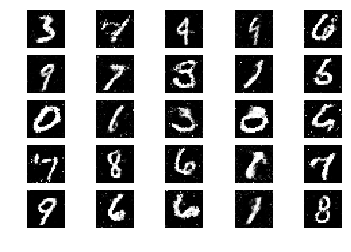

21000 [D loss: 0.656686, acc.: 58.33%] [G loss: 0.903567]
22000 [D loss: 0.651451, acc.: 62.88%] [G loss: 0.858180]
23000 [D loss: 0.672112, acc.: 56.44%] [G loss: 0.842080]
24000 [D loss: 0.673468, acc.: 53.03%] [G loss: 0.890796]
25000 [D loss: 0.656066, acc.: 60.98%] [G loss: 0.858908]
26000 [D loss: 0.676705, acc.: 59.09%] [G loss: 0.845018]
27000 [D loss: 0.647963, acc.: 61.36%] [G loss: 0.873987]
28000 [D loss: 0.639299, acc.: 59.47%] [G loss: 0.930542]
29000 [D loss: 0.668491, acc.: 56.06%] [G loss: 0.833575]
30000 [D loss: 0.637782, acc.: 63.64%] [G loss: 0.885186]


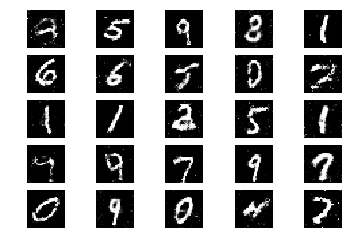

31000 [D loss: 0.680138, acc.: 53.79%] [G loss: 0.904595]
32000 [D loss: 0.637414, acc.: 64.02%] [G loss: 0.919162]
33000 [D loss: 0.650650, acc.: 65.91%] [G loss: 0.908313]
34000 [D loss: 0.670313, acc.: 59.85%] [G loss: 0.879753]
35000 [D loss: 0.627245, acc.: 64.77%] [G loss: 0.868682]
36000 [D loss: 0.638105, acc.: 61.74%] [G loss: 0.910659]
37000 [D loss: 0.622280, acc.: 62.88%] [G loss: 0.904945]
38000 [D loss: 0.625201, acc.: 68.18%] [G loss: 0.941318]
39000 [D loss: 0.640722, acc.: 62.50%] [G loss: 0.885646]
40000 [D loss: 0.632620, acc.: 63.64%] [G loss: 0.914355]


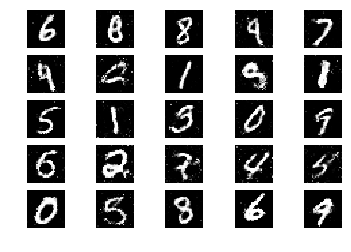

41000 [D loss: 0.660980, acc.: 56.06%] [G loss: 0.906089]
42000 [D loss: 0.665960, acc.: 58.71%] [G loss: 0.923200]
43000 [D loss: 0.634277, acc.: 64.77%] [G loss: 0.927393]
44000 [D loss: 0.621167, acc.: 67.05%] [G loss: 0.919399]
45000 [D loss: 0.626913, acc.: 64.39%] [G loss: 0.968635]
46000 [D loss: 0.645431, acc.: 63.26%] [G loss: 1.001628]
47000 [D loss: 0.612177, acc.: 66.67%] [G loss: 0.974626]
48000 [D loss: 0.641286, acc.: 63.64%] [G loss: 0.898557]
49000 [D loss: 0.627066, acc.: 63.64%] [G loss: 0.922826]
50000 [D loss: 0.621841, acc.: 63.64%] [G loss: 0.982606]


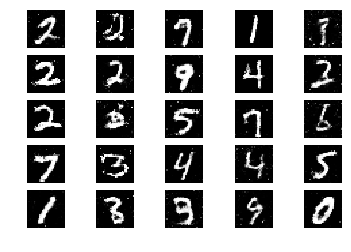

51000 [D loss: 0.647709, acc.: 60.61%] [G loss: 0.948445]
52000 [D loss: 0.638308, acc.: 59.85%] [G loss: 0.955856]
53000 [D loss: 0.671103, acc.: 60.23%] [G loss: 0.988261]
54000 [D loss: 0.636935, acc.: 62.50%] [G loss: 0.969917]
55000 [D loss: 0.634710, acc.: 60.98%] [G loss: 0.996688]
56000 [D loss: 0.637781, acc.: 59.47%] [G loss: 1.040337]
57000 [D loss: 0.611061, acc.: 59.47%] [G loss: 1.012631]
58000 [D loss: 0.657301, acc.: 57.58%] [G loss: 1.023502]
59000 [D loss: 0.629408, acc.: 64.02%] [G loss: 1.055135]
60000 [D loss: 0.618191, acc.: 65.91%] [G loss: 0.991862]


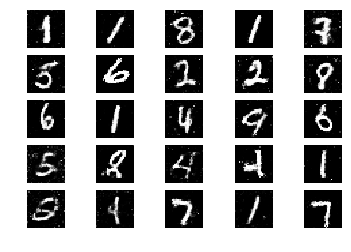

61000 [D loss: 0.648088, acc.: 61.74%] [G loss: 1.024130]
62000 [D loss: 0.605471, acc.: 64.02%] [G loss: 1.084983]
63000 [D loss: 0.618923, acc.: 65.15%] [G loss: 1.038328]
64000 [D loss: 0.631322, acc.: 63.26%] [G loss: 1.036802]
65000 [D loss: 0.617553, acc.: 67.80%] [G loss: 1.017450]
66000 [D loss: 0.576797, acc.: 71.97%] [G loss: 1.096682]
67000 [D loss: 0.614983, acc.: 66.29%] [G loss: 1.119081]
68000 [D loss: 0.611430, acc.: 68.94%] [G loss: 1.024460]
69000 [D loss: 0.609551, acc.: 69.70%] [G loss: 1.058961]
70000 [D loss: 0.611654, acc.: 66.29%] [G loss: 1.091580]


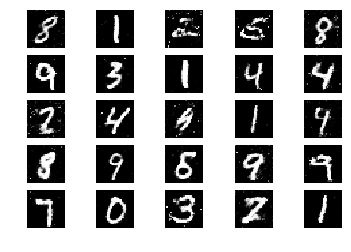

71000 [D loss: 0.591998, acc.: 68.94%] [G loss: 1.044735]
72000 [D loss: 0.593002, acc.: 68.56%] [G loss: 1.081943]
73000 [D loss: 0.605074, acc.: 64.77%] [G loss: 1.062384]
74000 [D loss: 0.590638, acc.: 68.94%] [G loss: 1.069198]
75000 [D loss: 0.648811, acc.: 64.02%] [G loss: 1.140224]
76000 [D loss: 0.581653, acc.: 70.08%] [G loss: 1.164085]
77000 [D loss: 0.595330, acc.: 67.05%] [G loss: 1.041199]
78000 [D loss: 0.597428, acc.: 68.94%] [G loss: 1.120026]
79000 [D loss: 0.598049, acc.: 67.05%] [G loss: 1.079045]
80000 [D loss: 0.628418, acc.: 65.53%] [G loss: 1.178035]


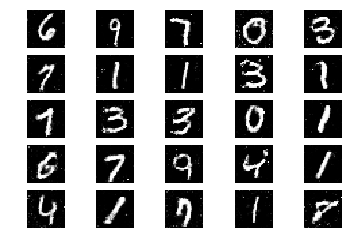

81000 [D loss: 0.579641, acc.: 70.08%] [G loss: 1.172992]
82000 [D loss: 0.573801, acc.: 68.56%] [G loss: 1.144777]
83000 [D loss: 0.581291, acc.: 67.42%] [G loss: 1.135954]
84000 [D loss: 0.555037, acc.: 73.48%] [G loss: 1.175380]
85000 [D loss: 0.583591, acc.: 68.18%] [G loss: 1.095266]
86000 [D loss: 0.635082, acc.: 62.50%] [G loss: 1.125767]
87000 [D loss: 0.584112, acc.: 68.56%] [G loss: 1.197955]
88000 [D loss: 0.571796, acc.: 67.80%] [G loss: 1.126958]
89000 [D loss: 0.600584, acc.: 67.42%] [G loss: 1.194109]
90000 [D loss: 0.570141, acc.: 70.08%] [G loss: 1.261497]


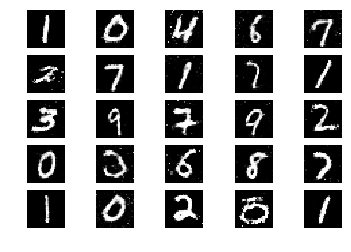

91000 [D loss: 0.543936, acc.: 71.21%] [G loss: 1.165997]
92000 [D loss: 0.542790, acc.: 73.11%] [G loss: 1.132252]
93000 [D loss: 0.589782, acc.: 70.45%] [G loss: 1.128940]
94000 [D loss: 0.601158, acc.: 65.15%] [G loss: 1.217646]
95000 [D loss: 0.545336, acc.: 70.45%] [G loss: 1.220573]
96000 [D loss: 0.594719, acc.: 67.42%] [G loss: 1.137719]
97000 [D loss: 0.573461, acc.: 69.70%] [G loss: 1.151532]
98000 [D loss: 0.535210, acc.: 74.24%] [G loss: 1.239794]
99000 [D loss: 0.584625, acc.: 66.29%] [G loss: 1.127383]


In [12]:
(X_train, _), (_, _) = mnist.load_data()
X_train = X_train / 127.5 - 1.
X_train = np.expand_dims(X_train, axis=3)

gan.train(X_train, epochs=100000, batch_size=132, sample_interval=10000)

### Save model and weights

In [0]:
gan.save('generator.h5')
gan.save_weights('generator_weights.h5')

### Load model and pre-trained weights

In [2]:
try: gan
except NameError: 
    gan = load_model('generator.h5')
    gan.load_weights('generator_weights.h5')

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


### Test model

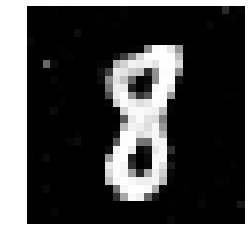

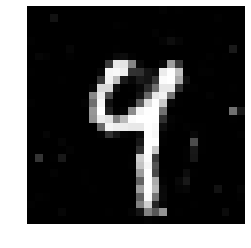

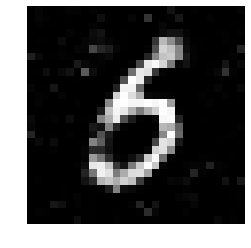

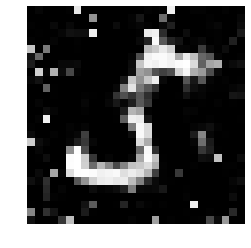

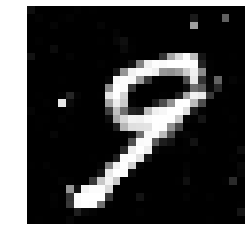

In [14]:
num_img = 5
noise = np.random.normal(0, 1, (num_img, 100))
gen_imgs = gan.predict(noise)
for i in range(5):
    plt.imshow(gen_imgs[i, :,:,0], cmap='gray')
    plt.axis('off')
    plt.show()
plt.close()